# Import libraries

In [101]:
import openml

import openml, pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pointbiserialr

# pd.set_option("display.max_columns", 100)

# Get dataset

In [102]:
# OpenML dataset 31 (German Credit). download metadata + data
ds = openml.datasets.get_dataset(31)  # 'credit-g'  OpenML
print("Name:", ds.name)
print("Default target:", ds.default_target_attribute)
print("Version:", ds.version)

# data as pandas DataFrame + target 
X, y, categorical, _ = ds.get_data(
    target=ds.default_target_attribute, # what is target attribute 
    dataset_format="dataframe"      # pandas dataframe
)

df = X.copy()
df[ds.default_target_attribute] = y
df.head()


Name: credit-g
Default target: class
Version: 1


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951.0,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096.0,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870.0,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,bad


There is no nan values in the dataset :)
### Rename attributes to be more intuitive

In [103]:
df = df.rename(columns={"installment_commitment": "installment_rate_category"})

# Start of EDA
## 1) Basic info (shapes, distribution ...)

In [104]:
print(df.shape)          # (1000, 21)
print("\n Basic info about dataset")
df.info()
print("\n")

target = ds.default_target_attribute

print(df[target].value_counts())


(1000, 21)

 Basic info about dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   checking_status            1000 non-null   category
 1   duration                   1000 non-null   uint8   
 2   credit_history             1000 non-null   category
 3   purpose                    1000 non-null   category
 4   credit_amount              1000 non-null   float64 
 5   savings_status             1000 non-null   category
 6   employment                 1000 non-null   category
 7   installment_rate_category  1000 non-null   uint8   
 8   personal_status            1000 non-null   category
 9   other_parties              1000 non-null   category
 10  residence_since            1000 non-null   uint8   
 11  property_magnitude         1000 non-null   category
 12  age                        1000 non-null   uint8   
 

## What is the quality of data? (NaN values, duplicites)

In [105]:
# nan values in every columns
nan_counts = df.isna().sum().sort_values(ascending=False)
print(nan_counts)
# print(nan_counts[nan_counts > 0])

# are any rows duplicated?
print("\nNumber of duplicated rows")
print(df.duplicated().sum())

# numeric attributes
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# categorical attributes
category_cols = df.select_dtypes(include=["object", "category"]).columns.drop(target, errors="ignore").tolist()
print(f"\nCategorical attributes:\n {category_cols}")




checking_status              0
property_magnitude           0
foreign_worker               0
own_telephone                0
num_dependents               0
job                          0
existing_credits             0
housing                      0
other_payment_plans          0
age                          0
residence_since              0
duration                     0
other_parties                0
personal_status              0
installment_rate_category    0
employment                   0
savings_status               0
credit_amount                0
purpose                      0
credit_history               0
class                        0
dtype: int64

Number of duplicated rows
0

Categorical attributes:
 ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']


In [106]:
df[num_cols].describe().T 

,count,mean,std,min,25%,50%,75%,max
duration,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0
credit_amount,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
installment_rate_category,1000.0,2.973,1.118715,1.0,2.0,3.0,4.00,4.0
residence_since,1000.0,2.845,1.103718,1.0,2.0,3.0,4.00,4.0
age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0
existing_credits,1000.0,1.407,0.577654,1.0,1.0,1.0,2.00,4.0
num_dependents,1000.0,1.155,0.362086,1.0,1.0,1.0,1.00,2.0


- Duration of some credits are really short - 4 months
- Credit amount - median is 2320, but max is 18424 -> normalization will be needed (right skew)
- Installment_rate_category is more like categorical attribute - range 1-4
- Residence_since also categorical attribute - range 1-4
- existing_credits - most people have 1-2 credits at the same time - max is 4 (maybe larger risk)
- 

In [107]:
df[num_cols].notna().sum()

duration                     1000
credit_amount                1000
installment_rate_category    1000
residence_since              1000
age                          1000
existing_credits             1000
num_dependents               1000
dtype: int64

## Cardinality of categories

In [108]:
card = (
    df[category_cols]
    .nunique()
    .sort_values(ascending=False)
    .rename("n_unique")
    .to_frame()
)
card


,n_unique
purpose,10
credit_history,5
savings_status,5
employment,5
checking_status,4
personal_status,4
property_magnitude,4
job,4
other_parties,3
other_payment_plans,3


One-hot encoding is reasonable

In [109]:
print(df["job"].unique())

['skilled', 'unskilled resident', 'high qualif/self emp/mgmt', 'unemp/unskilled non res']
Categories (4, object): ['unemp/unskilled non res' < 'unskilled resident' < 'skilled' < 'high qualif/self emp/mgmt']


## Visualisations
### Normality of numeric data

,feature,k2,p_value,mean,std,skew,kurtosis
3,residence_since,22019.260017,0.000000e+00,2.845,1.103166,-0.272161,-1.380545
2,installment_rate_category,842.425283,1.174016e-183,2.973,1.118155,-0.530551,-1.210423
1,credit_amount,396.042171,1.001233e-86,3271.258,2821.325155,1.946702,4.265163
6,num_dependents,325.065355,2.587945e-71,1.155,0.361905,1.906579,1.635045
5,existing_credits,208.700530,4.800159e-46,1.407,0.577366,1.270666,1.590434
0,duration,156.054121,1.298010e-34,20.903,12.052784,1.092542,0.909195
4,age,133.888657,8.442042e-30,35.546,11.369779,1.019208,0.586811


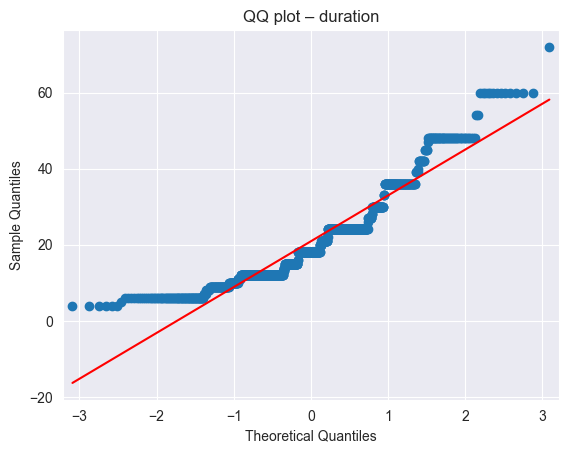

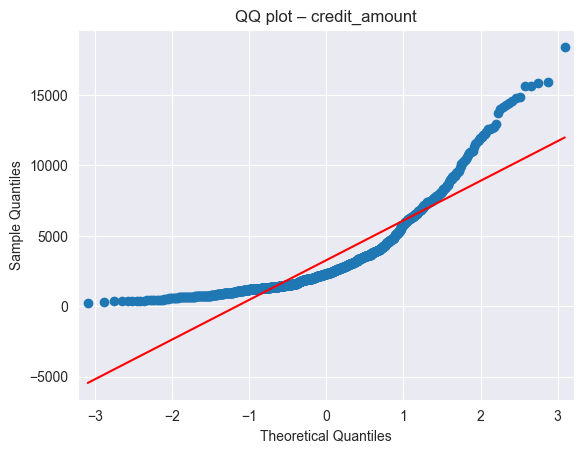

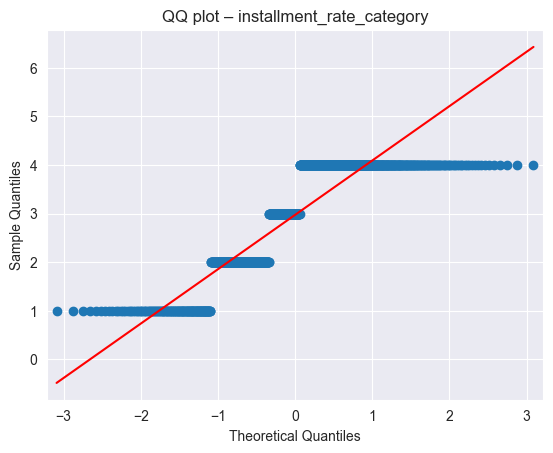

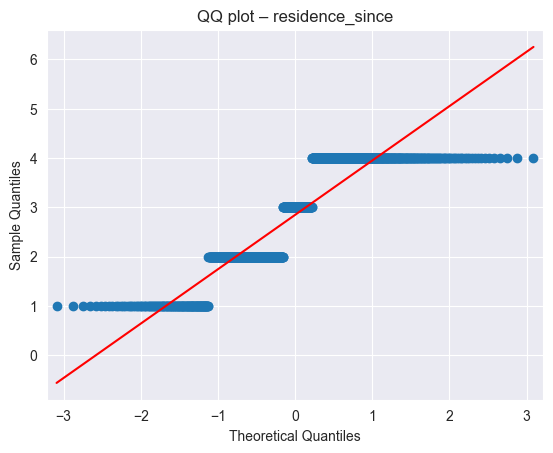

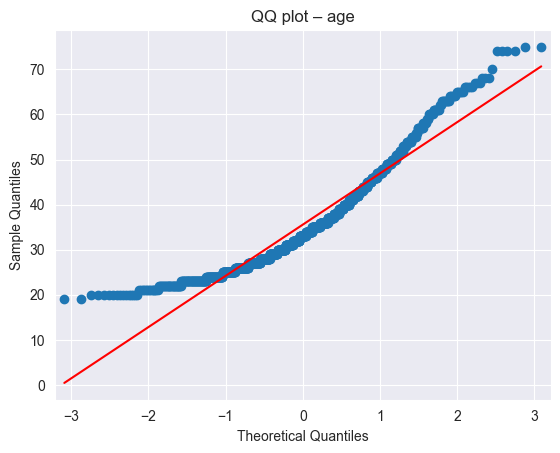

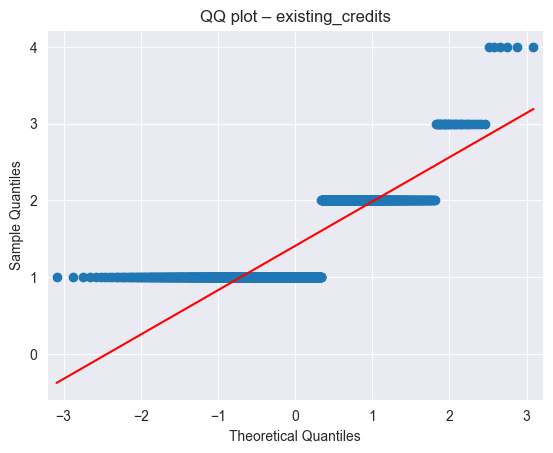

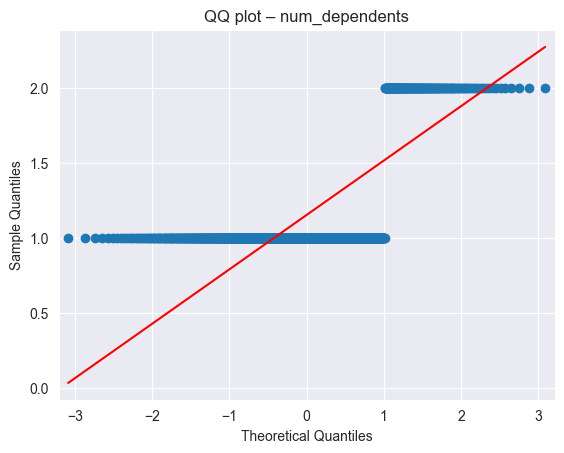

In [110]:
from statsmodels.graphics.gofplots import qqplot
import warnings; warnings.filterwarnings("ignore")

results_normality = []
for c in num_cols:
    x = pd.to_numeric(df[c], errors="coerce").dropna().astype(float)
    # D’Agostino K² (more robust for bigger N than Shapiro)
    k2_stat, p = stats.normaltest(x)
    results_normality.append((c, k2_stat, p, np.mean(x), np.std(x), stats.skew(x), stats.kurtosis(x)))

norm_table = (pd.DataFrame(results_normality, columns=["feature","k2","p_value","mean","std","skew","kurtosis"])
                .sort_values("p_value"))
display(norm_table)

# QQ plots
for c in num_cols:
    fig = qqplot(df[c], line='s')
    plt.title(f"QQ plot – {c}")
    plt.show()


##### Pre všetky kontrolované numerické stĺpce vyšla výrazná nenormalita (p-hodnoty ≪ 0.05).

Testy a metriky - neparametricke porovnania medzi triedami (Mann-Whitney radsej ako T-test)

### Histograms of numeric attributes

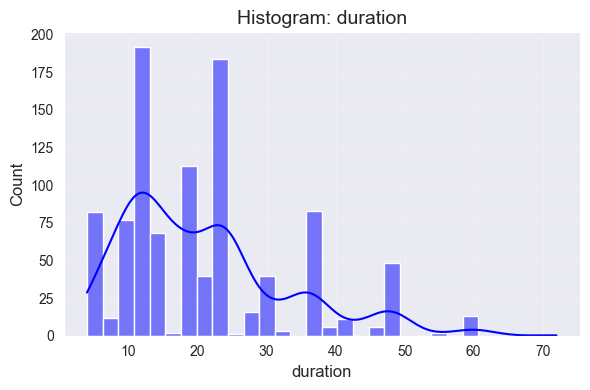

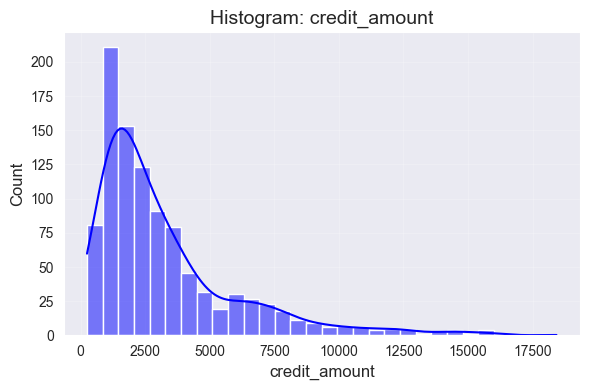

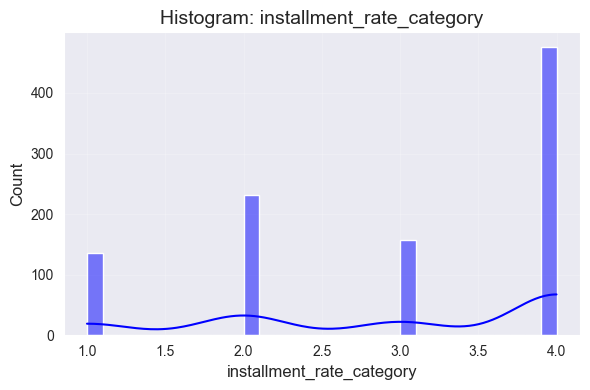

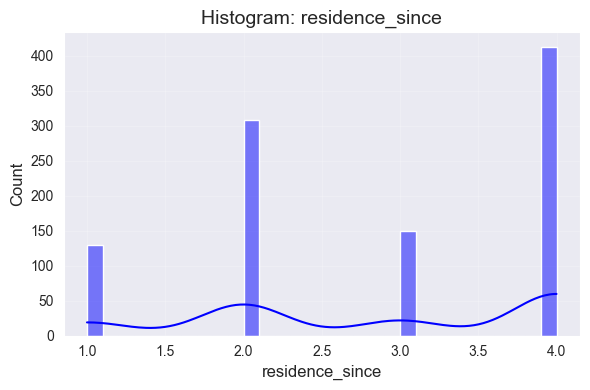

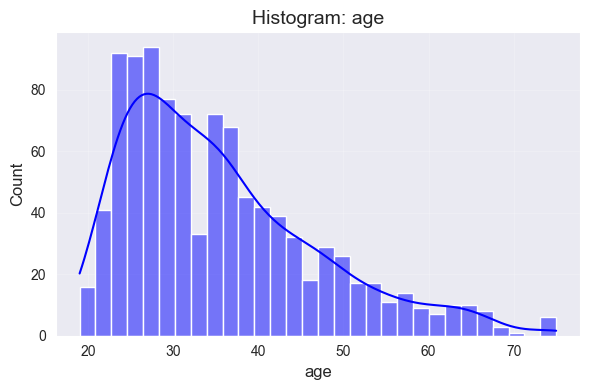

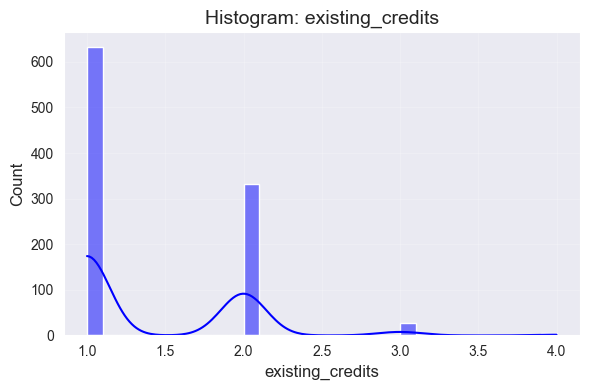

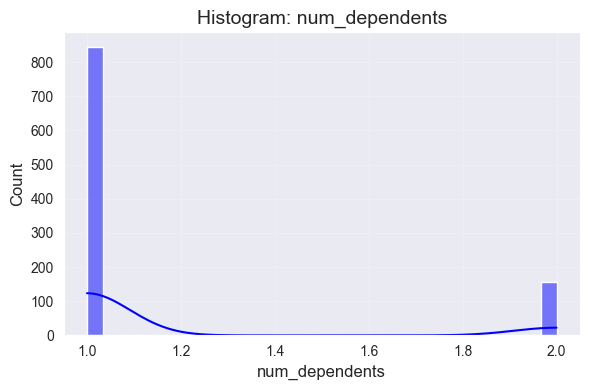

In [111]:
for c in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(
        data=df, 
        x=c, 
        bins=30, 
        kde=True,
        color="blue",      # choose a nice color
        edgecolor="white"     # improve bar contrast
    )
    plt.title(f"Histogram: {c}", fontsize=14)
    plt.xlabel(c, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()


- Duration - Most loans are short: 12–24 months and very few goes above 48 months longer durations may correlate with higher risk or special cases
- Credit amount - Very right-skewed (long tail): a few customers take very large loans

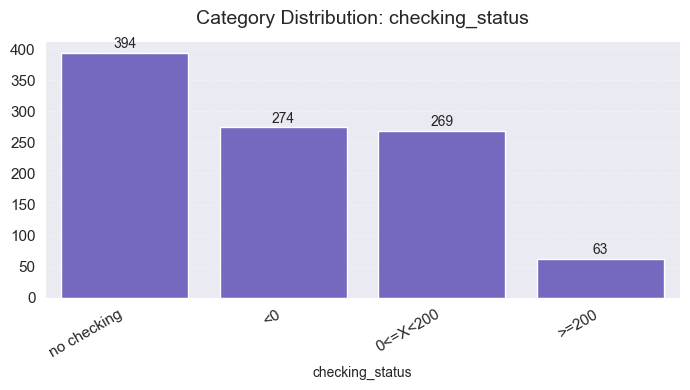

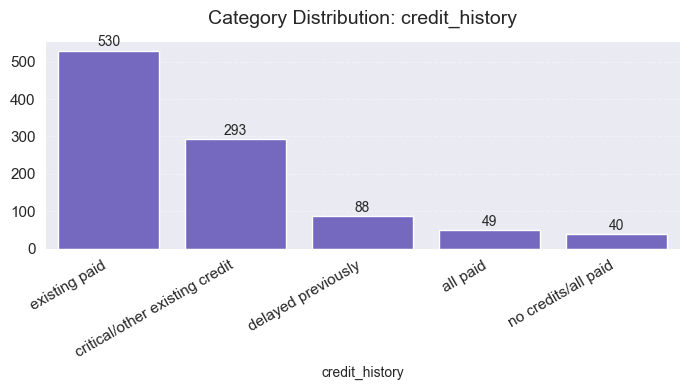

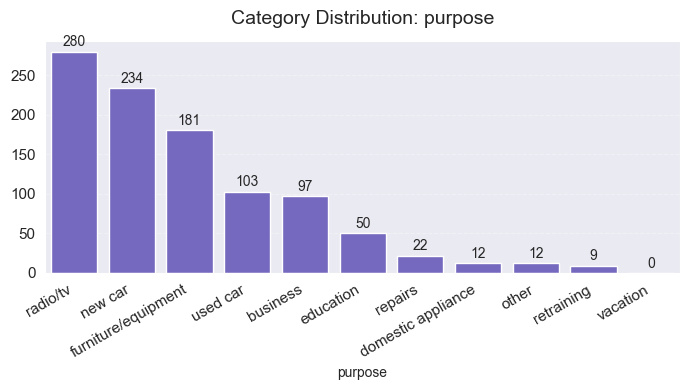

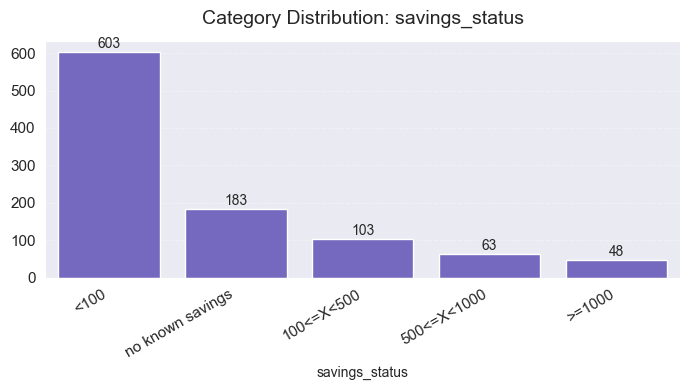

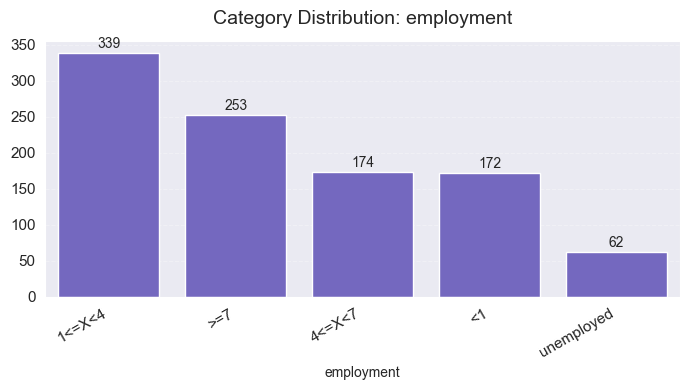

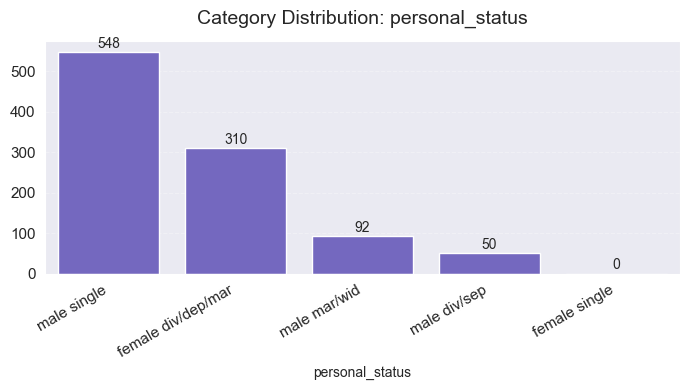

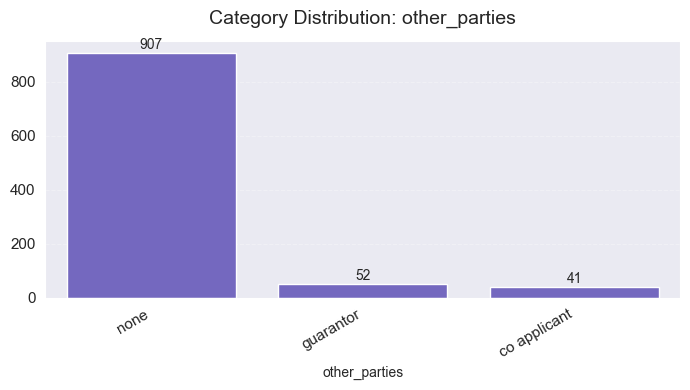

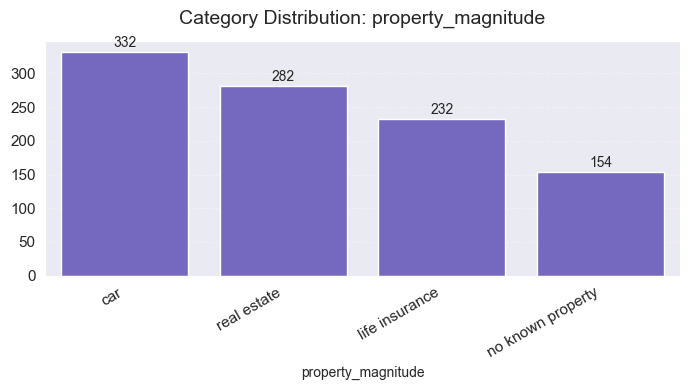

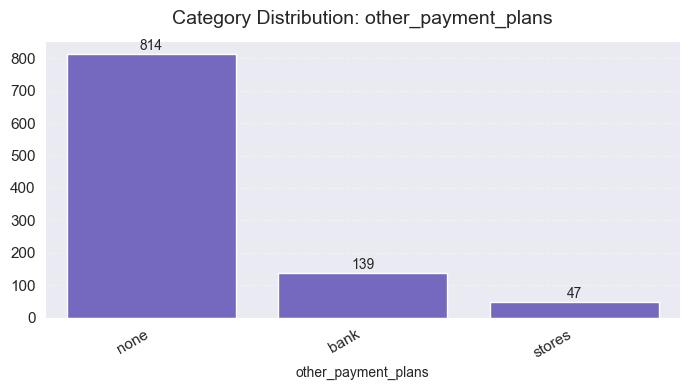

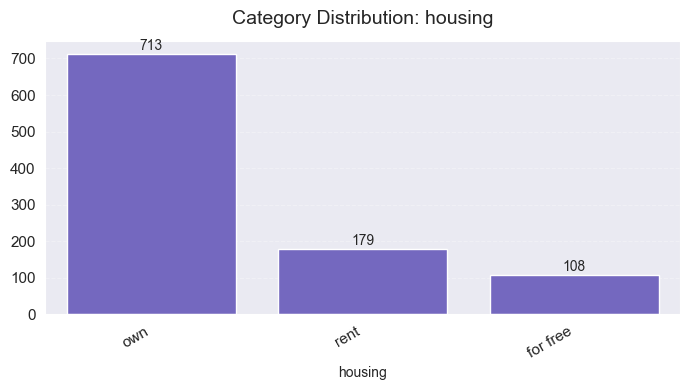

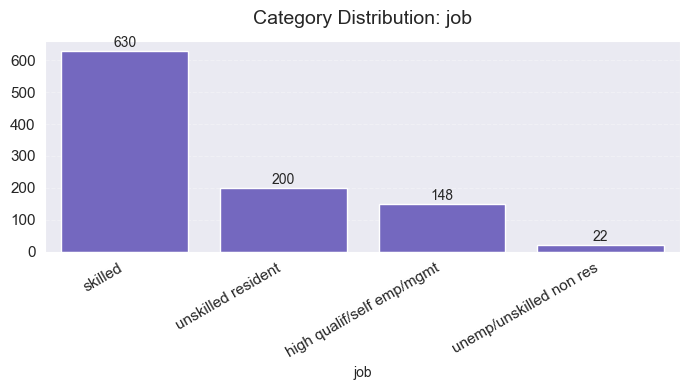

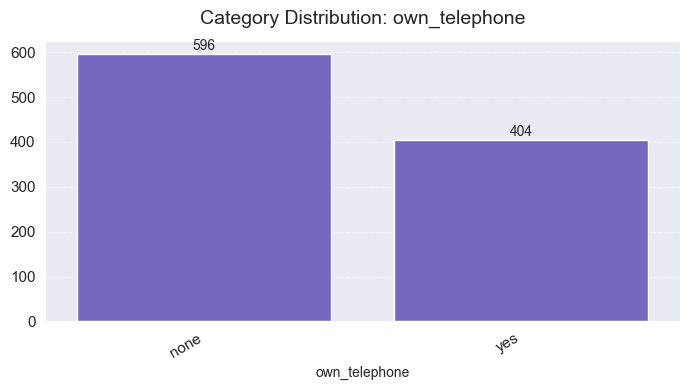

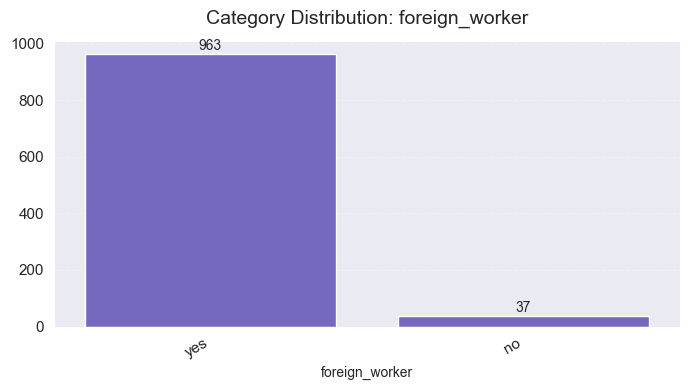

In [112]:
TOP = 12

for c in category_cols:
    vc = df[c].value_counts().head(TOP)

    plt.figure(figsize=(7,4))

    sns.barplot(
        x=vc.index.astype(str),
        y=vc.values,
        color="slateblue",   # ✅ solid color fixes warning
        edgecolor="white"
    )

    plt.title(f"Category Distribution: {c}", fontsize=14, pad=12)
    plt.xticks(rotation=30, ha="right", fontsize=11)
    plt.yticks(fontsize=11)
    plt.grid(axis="y", linestyle="--", alpha=0.3)

    for i, v in enumerate(vc.values):
        plt.text(i, v + 3, str(v), ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()


## Violin plot based on target

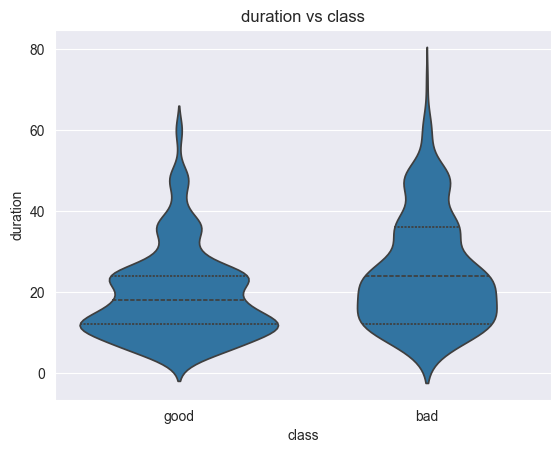

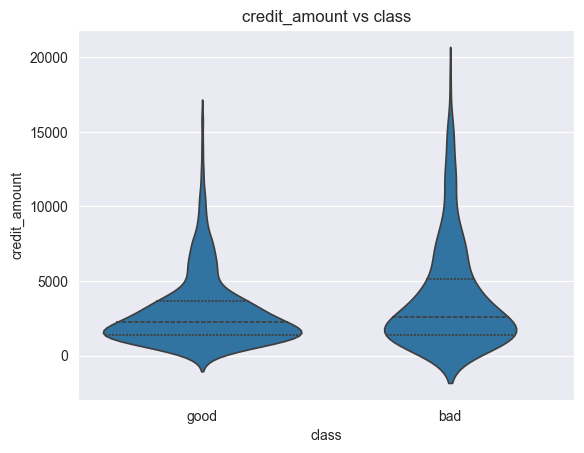

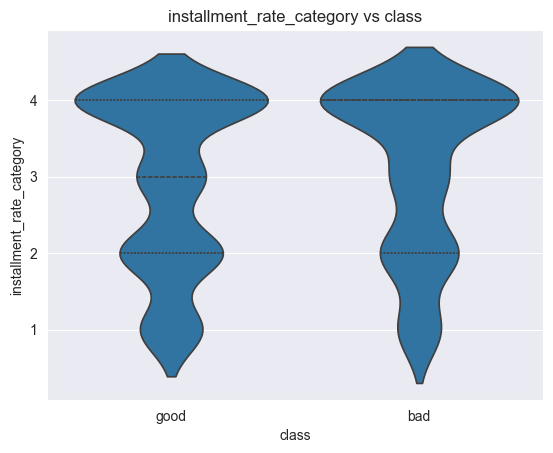

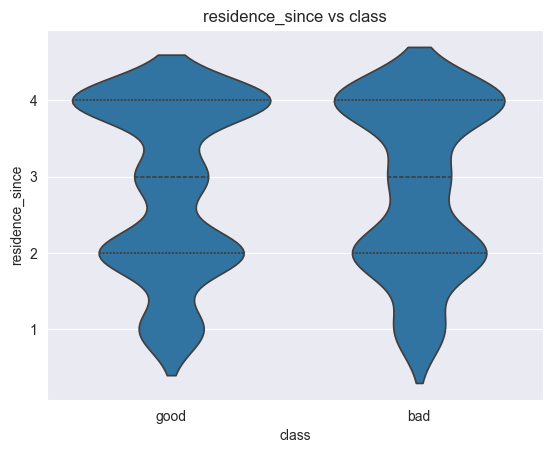

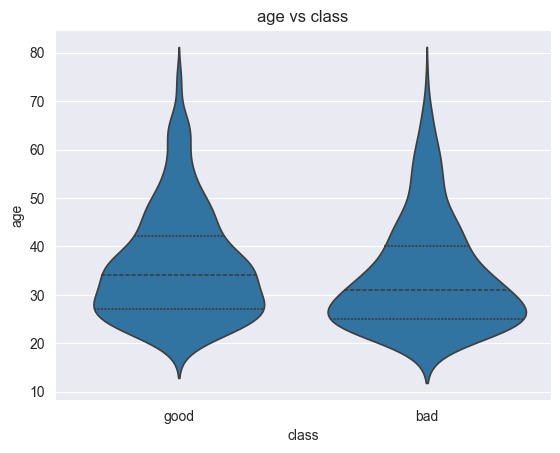

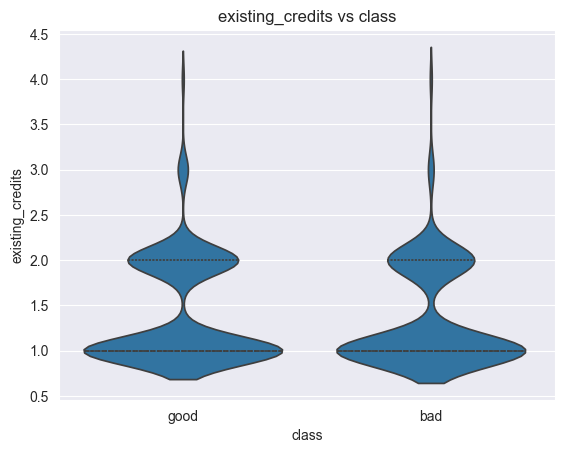

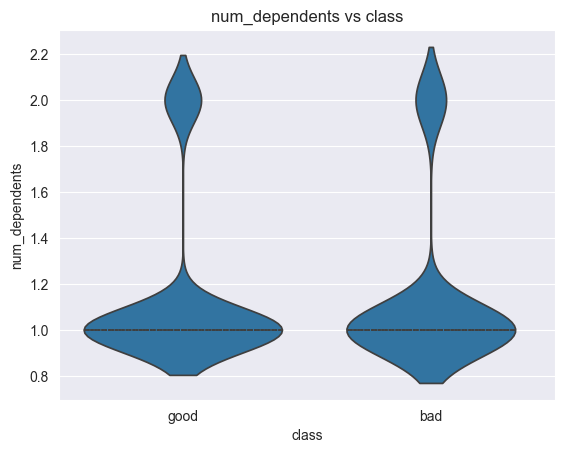

In [113]:
for c in num_cols:
    fig, ax = plt.subplots()
    sns.violinplot(data=df, x=target, y=c, inner="quartile")
    ax.set_title(f"{c} vs {target}")
    plt.show()


# Correlations and heatmap

Pearson - ako su si vsetky atributy navzajom podobne - predpoklada pribliznu linearitu a kontinuitu

In [114]:
# Convert the target into a binary numeric form
# print(df[target])
y_bin = (df[target].astype(str).str.lower() == "bad").astype(int)
# print(y_bin)

# One-hot encode categorical features – drop_first=True prevents perfect
# multicollienarity (dummy trap)
df_enc = pd.get_dummies(df.drop(columns=[target]), drop_first=True)

# correlation matrix
corr = df_enc.corr(numeric_only=True)

# correlation with target
corr_target = df_enc.assign(_y=y_bin) \
                    .corr(numeric_only=True)['_y'] \
                    .drop('_y') \
                    .sort_values(key=np.abs, ascending=False)

corr_target.head(20)


checking_status_no checking                     -0.322436
duration                                         0.214927
credit_history_critical/other existing credit   -0.181713
credit_amount                                    0.154739
housing_own                                     -0.134589
credit_history_all paid                          0.134448
savings_status_no known savings                 -0.129238
property_magnitude_no known property             0.125750
checking_status_0<=X<200                         0.119581
other_payment_plans_none                        -0.113285
purpose_radio/tv                                -0.106922
employment_<1                                    0.106397
purpose_used car                                -0.099791
age                                             -0.091127
savings_status_>=1000                           -0.085749
foreign_worker_no                               -0.082079
housing_for free                                 0.081556
personal_statu

Spearmen je robustensji - Sú numerické premenné monotónne závislé? (nemusí byť lineárne)

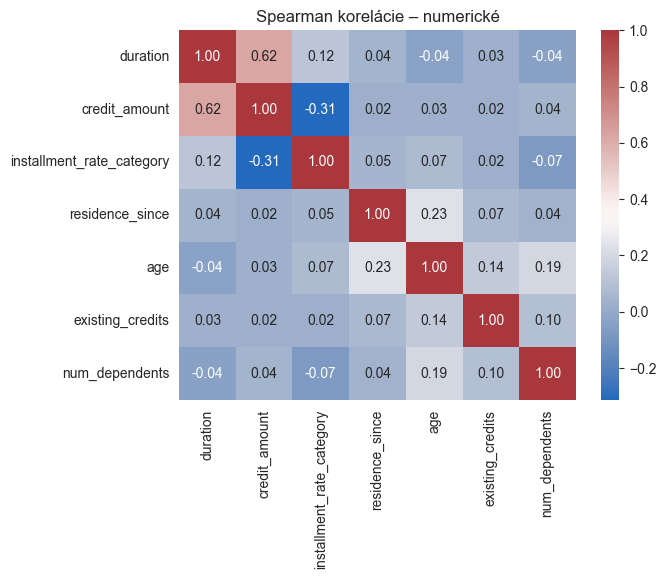

,feature,r_pb,p_value
0,duration,0.214927,6.488050e-12
1,credit_amount,0.154739,8.797572e-07
4,age,-0.091127,3.925339e-03
2,installment_rate_category,0.072404,2.203549e-02
5,existing_credits,-0.045732,1.484198e-01
6,num_dependents,-0.003015,9.241409e-01
3,residence_since,0.002967,9.253374e-01


In [115]:
spearman_mat = df[num_cols].corr(method="spearman")
sns.heatmap(spearman_mat, annot=True, fmt=".2f", cmap="vlag")
plt.title("Spearman korelácie – numerické"); plt.show()

# Point-biserial pre num vs binárny cieľ (ekvivalent Pearson s binárnym)

rows=[]
for c in num_cols:
    r, p = pointbiserialr(df[c], y_bin)
    rows.append((c, r, p))
pd.DataFrame(rows, columns=["feature","r_pb","p_value"]).sort_values("p_value")


Silna vazba cim dlhsia splatnost, tym vacsi uver 

-0.31 vyssia katergoria splatky (percento z prijmu) ide typicky s mensim uverom vyššia kategória splátky (percento z príjmu)

# Mutual information

In [116]:
from sklearn.feature_selection import mutual_info_classif
X_enc = pd.get_dummies(df.drop(columns=[target]), drop_first=True)
mi = mutual_info_classif(X_enc, y_bin, discrete_features=X_enc.dtypes!=float, random_state=42)
mi_series = pd.Series(mi, index=X_enc.columns).sort_values(ascending=False)
mi_series.head(30)


checking_status_no checking                      0.056778
duration                                         0.043914
age                                              0.031598
credit_history_critical/other existing credit    0.017686
credit_amount                                    0.011884
savings_status_no known savings                  0.009065
housing_own                                      0.008802
credit_history_all paid                          0.008186
property_magnitude_no known property             0.007492
checking_status_0<=X<200                         0.006945
other_payment_plans_none                         0.006149
purpose_radio/tv                                 0.005934
purpose_used car                                 0.005511
employment_<1                                    0.005420
savings_status_>=1000                            0.004295
foreign_worker_no                                0.004036
personal_status_male single                      0.003246
housing_for fr

kolko neurcitosti znizime ak pozname dany atribut?

checking_status_no - najsilnejsi

takisto je duration sama o sebe dost informativna

### Bad rate by category

In [117]:
def bad_rate_by_category(col):
    tmp = (
        df[[col]].assign(y=y_bin)
          .groupby(col, observed=False)['y'].mean()  
          .sort_values(ascending=False)
          .rename("bad_rate")
          .to_frame()
    )
    return tmp

# (napr. 'credit_history', 'checking_status', 'purpose')
for col in [c for c in category_cols if c.lower().startswith(("credit", "check", "purp"))][:3]:
    display(bad_rate_by_category(col).head(15))


,bad_rate
checking_status,
<0,0.492701
0<=X<200,0.390335
>=200,0.222222
no checking,0.116751


,bad_rate
credit_history,
no credits/all paid,0.625000
all paid,0.571429
existing paid,0.318868
delayed previously,0.318182
critical/other existing credit,0.170648


,bad_rate
purpose,
education,0.440000
other,0.416667
new car,0.380342
repairs,0.363636
business,0.350515
domestic appliance,0.333333
furniture/equipment,0.320442
radio/tv,0.221429
used car,0.165049


- ten kto sa necheckuje - velke rizikov
- prekvapivo vysoke riziko niekoho kto ma vsetky dlhy splatene (moze byt sum z par pripadov, mozno miesanie s vekom a podobne)
- 

In [118]:
import statsmodels.api as sm

def bad_rate_table(col):
    g = df.assign(y=y_bin).groupby(col, observed=False)['y'].agg(['mean','count'])
    ci = g.apply(lambda r: sm.stats.proportion_confint(int(r['mean']*r['count']),
                                                      r['count'], method='wilson'), axis=1)
    g['ci_low']  = ci.map(lambda x: x[0])
    g['ci_high'] = ci.map(lambda x: x[1])
    return g.sort_values('mean', ascending=False)

display(bad_rate_table('checking_status'))
display(bad_rate_table('credit_history'))


,mean,count,ci_low,ci_high
checking_status,,,,
<0,0.492701,274,0.434016,0.551588
0<=X<200,0.390335,269,0.333974,0.449783
>=200,0.222222,63,0.137250,0.339123
no checking,0.116751,394,0.088681,0.152223


,mean,count,ci_low,ci_high
credit_history,,,,
no credits/all paid,0.625000,40,0.470324,0.757770
all paid,0.571429,49,0.432705,0.699767
existing paid,0.318868,530,0.280617,0.359726
delayed previously,0.318182,88,0.230226,0.421348
critical/other existing credit,0.170648,293,0.131903,0.217919


## Hypothesis testing  

**Hypoteza 0:** Medzi dobrými a zlými klientmi nie je rozdiel v dĺžke trvania úveru (duration). 

**Hypoteza 1:** Medzi dobrými a zlými klientmi existuje rozdiel v dĺžke trvania úveru (duration).

In [119]:
good_duration = df[df["class"] == "good"]["duration"]
bad_duration = df[df["class"] == "bad"]["duration"]

Využijeme Shapiro-Wilkom test aby sme zistili, či je rozdelenie normálne.

In [120]:
good = stats.shapiro(good_duration)
bad = stats.shapiro(bad_duration)
print(good)
print(bad)

ShapiroResult(statistic=np.float64(0.8940428396899388), pvalue=np.float64(1.5303819115920704e-21))
ShapiroResult(statistic=np.float64(0.9160708543398846), pvalue=np.float64(6.478560226120272e-12))


Kedze pri oboch testoch p < 0.5 - vyuzijeme MannWhitney U test.

In [121]:
stats.mannwhitneyu(good_duration, bad_duration, alternative="greater")

MannwhitneyuResult(statistic=np.float64(77995.5), pvalue=np.float64(0.9999999999601555))

Keďže p > 0.05 - je skoro až 1, nemáme dôkaz že by sa „dobrí“ klienti líšili od „zlých“ v dĺžke trvania úveru.

# Outliers (IQR) and transformations

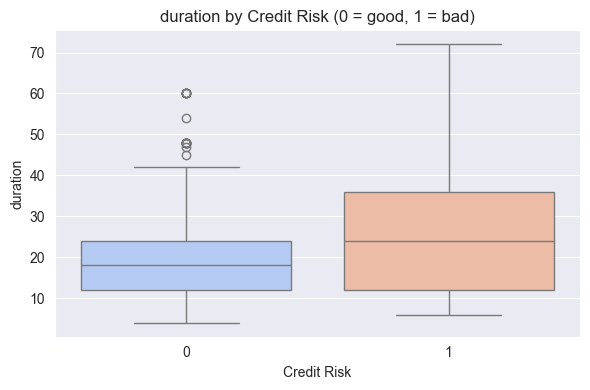

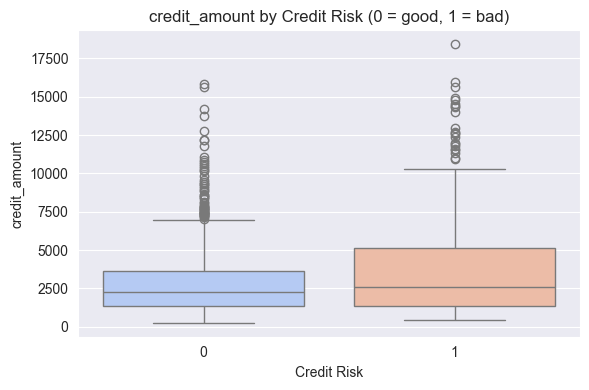

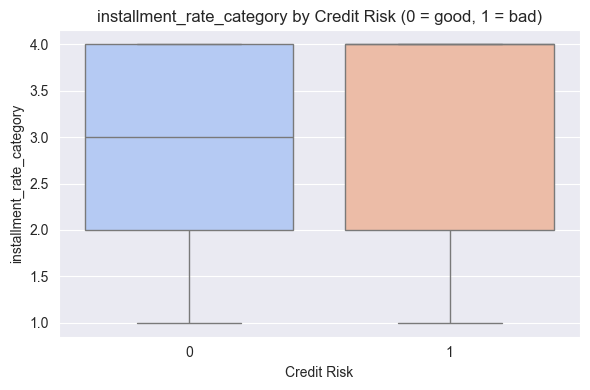

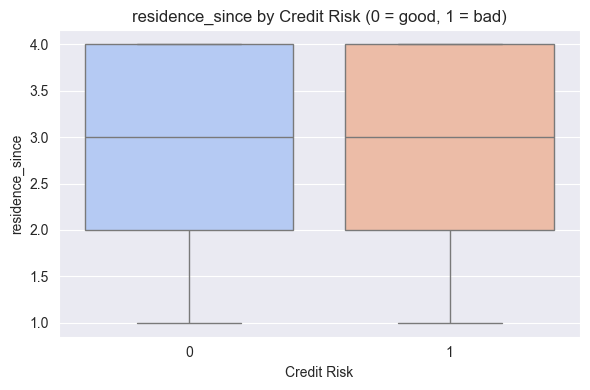

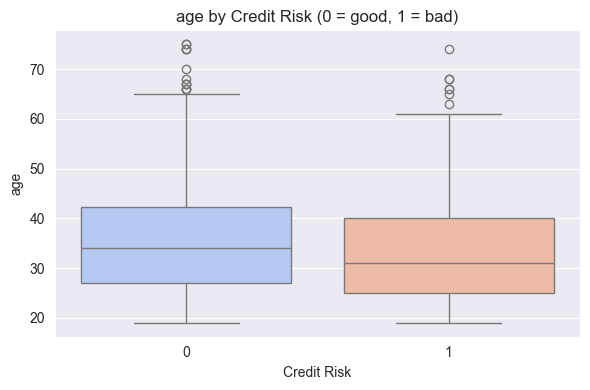

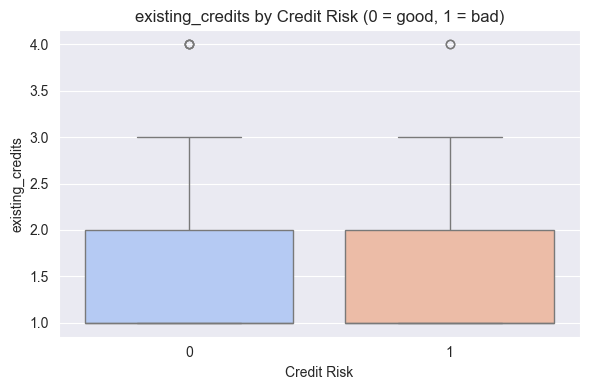

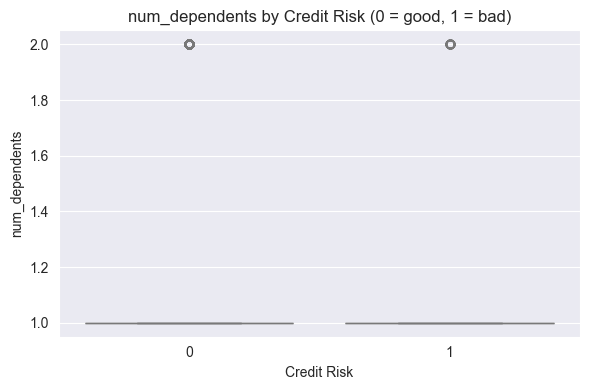

In [122]:
for c in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(
        data=df,
        x=y_bin,
        y=c,
        hue=y_bin,           
        palette="coolwarm",   
        showfliers=True
    )
    plt.title(f"{c} by Credit Risk (0 = good, 1 = bad)")
    plt.xlabel("Credit Risk")
    plt.legend([],[], frameon=False)
    plt.tight_layout()
    plt.show()


In [123]:
from collections import defaultdict
iqr_flags = defaultdict(int)

for c in num_cols:
    q1, q3 = df[c].quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    iqr_flags[c] = ((df[c] < lo) | (df[c] > hi)).sum()

pd.Series(iqr_flags).sort_values(ascending=False).rename("n_outliers")


num_dependents               155
credit_amount                 72
duration                      70
age                           23
existing_credits               6
installment_rate_category      0
residence_since                0
Name: n_outliers, dtype: int64

Ukazka transformacie pre credit_amount - log transformation

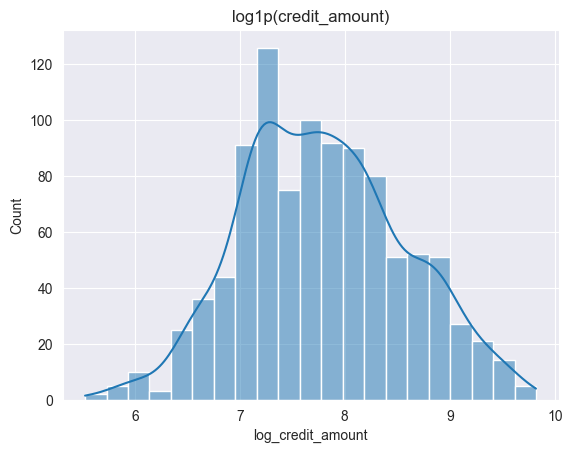

In [124]:
def mad_outliers(x, k=3.5):
    x = x.astype(float)
    med = np.median(x)
    mad = np.median(np.abs(x - med)) or 1e-9
    z = 0.6745 * (x - med) / mad
    return np.sum(np.abs(z) > k)

rob = {c: mad_outliers(df[c].values) for c in num_cols}
pd.Series(rob, name="n_outliers_MAD").sort_values(ascending=False)

# Návrhy transformácií: log pre pravostrannú šikmosť
df_tf = df.copy()
for c in ["credit_amount"]:
    df_tf[f"log_{c}"] = np.log1p(df_tf[c])

sns.histplot(df_tf["log_credit_amount"], kde=True)
plt.title("log1p(credit_amount)"); plt.show()

# Short summary for EDA

In [125]:
summary = {
    "n_rows": df.shape[0],
    "n_cols": df.shape[1],
    "n_num": len(num_cols),
    "n_cat": len(category_cols),
    "class_ratio": df[target].value_counts(normalize=True).to_dict(),
    "has_na": int(df.isna().any().any())
}
summary


{'n_rows': 1000,
 'n_cols': 21,
 'n_num': 7,
 'n_cat': 13,
 'class_ratio': {'good': 0.7, 'bad': 0.3},
 'has_na': 0}

Ciel a data

„German Credit“ dataset (1000 riadkov, 21 stlpcov vratane ciela class). Triedy su mierne nevyvazene (good ~70 % / bad ~30 %), preto budem pri modelovani pouzivat stratifikovane delenie.

Kvalita dat
Chybajuce hodnoty ani duplicity som nenasiel. Typy su rozumne: zopar numerickych stlpcov a viac kategorickych (nominálne aj ordinalne).

Distribucie a normalita

Numericke premenne su vyrazne nenormalne (pravostranny chvost najma pri credit_amount, zhluk okolo 12–24 mesiacov pri duration). Na porovnavanie skupin preto volim neparametricke testy a pri modelovaní robustne skalovanie; pre credit_amount davam log1p.

Vztah k cielu

Najsilnejsi signal maju kategoricke premenne ako checking_status a casti credit_history. Z numerickych niesu „striebornou gulou“, ale signal tam je: duration a credit_amount su informatívne, age ma slabsi negativny vztah. Bad-rate tabulky pre kategorie rozdiely pekne odhaluju.

Hypotezove testy

Kedze normalita v triedach neplati, pouzivam Mann–Whitney U namiesto t-testu. Samotna duration triedy vyrazne neoddeluje, ale v kombinacii s dalsimi znakmi pridava signal.

Outliery a transformacie

IQR najviac flaguje odlahlosti pri credit_amount (co riesim log1p) a pri niektorych nizko-kardinalitnych diskretnych stlpcoch, kde sa nespolieham len na IQR a pozeram aj robustne metriky (MAD) a bad-rate.

Priprava features

Kategoricke: one-hot pre nominalne; pre ordinalne zvazujem ordinalne kodovanie (aby som nezahodil poradie).
Numericke: robust scaler / standardizacia; kontrola multikolinearity po one-hot.
Zachovavam zmysluplne poradia (installment_rate, residence_since).

Implikacie pre modelovanie

Na baseline idem s logistickou regresiou (so skalovanim) a stromovymi metodami (RF/GB). Sledujem interakcie ako duration × credit_amount a checking_status × credit_history. Validacia bude stratifikovana, metriky ROC-AUC, PR-AUC a F1; pri nevyvazenosti pouzijem class weights.
